In [1]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbMetricsLogger
import resnets as rn

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Set hyperparameters

Hyperparameters are inspired by *Deep Residual Learning for Image Recognition* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun (2015).

In [3]:
train_path = "facial-affect-dataset-unbalanced/train"
test_path = "facial-affect-dataset-unbalanced/test"

image_size = 96
channels = 3
color_mode = "rgb"
validation_split = 0.2
seed = 27

config = {
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.1,
    "momentum": 0.9,
    "l2": 0.0001,
    "early_stop_patience": 10,
    "lr_reduce_patience": 5
}

## Run the following block on Kaggle only!

In [4]:
train_path = "/kaggle/input/" + train_path
test_path = "/kaggle/input/" + test_path

## Get class names

In [5]:
classes = next(os.walk(train_path))[1]
print(classes)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


## Create training, validation and test datasets

In [6]:
train, validation = image_dataset_from_directory(
    directory=train_path,
    validation_split=validation_split,
    subset="both",
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    seed=seed,
    shuffle=True
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    shuffle=False
)

Found 23234 files belonging to 8 classes.
Using 18588 files for training.
Using 4646 files for validation.
Found 5808 files belonging to 8 classes.


## Training on different models with SOTA hyperparameters

### ResNet-18 - training and evaluation

In [7]:
wandb.init(config=config, project='resnet', name='resnet18')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet18(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


Epoch 1/100
581/581 [==============================] - 55s 80ms/step - loss: 3.9717 - sparse_categorical_accuracy: 0.1727 - val_loss: 3.2918 - val_sparse_categorical_accuracy: 0.1821 - lr: 0.1000
Epoch 2/100
581/581 [==============================] - 18s 31ms/step - loss: 2.8820 - sparse_categorical_accuracy: 0.2689 - val_loss: 2.4876 - val_sparse_categorical_accuracy: 0.3861 - lr: 0.1000
Epoch 3/100
581/581 [==============================] - 19s 32ms/step - loss: 2.3125 - sparse_categorical_accuracy: 0.4224 - val_loss: 2.1235 - val_sparse_categorical_accuracy: 0.4791 - lr: 0.1000
Epoch 4/100
581/581 [==============================] - 18s 31ms/step - loss: 2.0412 - sparse_categorical_accuracy: 0.4747 - val_loss: 1.9996 - val_sparse_categorical_accuracy: 0.4796 - lr: 0.1000
Epoch 5/100
581/581 [==============================] - 18s 31ms/step - loss: 1.8402 - sparse_categorical_accuracy: 0.5123 - val_loss: 1.8773 - val_sparse_categorical_accuracy: 0.4826 - lr: 0.1000
Epoch 6/100
581/581 

epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,█████████████▂▂▂▂▂▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch/lr,██████████████▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▂▃▄▄▄▄▅▅▅▅▅▆▆▇▇███
epoch/val_loss,█▅▄▃▃▂▁▁▁▁▂▁▂▂▁▂▃▄▄
epoch/val_sparse_categorical_accuracy,▁▄▆▆▆▆▇▇▇▆▆▇▆▇█████
epoch/epoch,18
epoch/learning_rate,0.001
epoch/loss,0.46039
epoch/lr,0.01


182/182 [==============================] - 12s 65ms/step - loss: 1.5002 - sparse_categorical_accuracy: 0.5658


[1.5002371072769165, 0.5657713413238525]

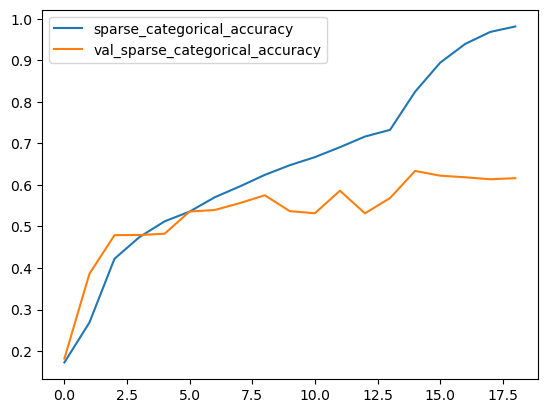

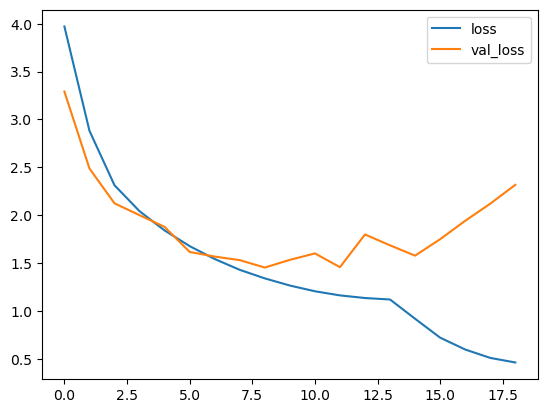

In [8]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-34 - training and evaluation

In [9]:
wandb.init(config=config, project='resnet', name='resnet34')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet34(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
581/581 [==============================] - 33s 49ms/step - loss: 8.6565 - sparse_categorical_accuracy: 0.1744 - val_loss: 7.2433 - val_sparse_categorical_accuracy: 0.1782 - lr: 0.1000
Epoch 2/100
581/581 [==============================] - 27s 47ms/step - loss: 6.6793 - sparse_categorical_accuracy: 0.1742 - val_loss: 6.1610 - val_sparse_categorical_accuracy: 0.1789 - lr: 0.1000
Epoch 3/100
581/581 [==============================] - 27s 47ms/step - loss: 5.7190 - sparse_categorical_accuracy: 0.1765 - val_loss: 5.3069 - val_sparse_categorical_accuracy: 0.1782 - lr: 0.1000
Epoch 4/100
581/581 [==============================] - 27s 46ms/step - loss: 4.9568 - sparse_categorical_accuracy: 0.1758 - val_loss: 4.6284 - val_sparse_categorical_accuracy: 0.1782 - lr: 0.1000
Epoch 5/100
581/581 [==============================] - 27s 47ms/step - loss: 4.3550 - sparse_categorical_accuracy: 0.1747 - val_loss: 4.0942 - val_sparse_categorical_accuracy: 0.1778 - lr: 0.1000
Epoch 6/100
581/581 

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████████████████████▂▂▂▂▂▂▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████████████████▂▂▂▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▁▂▃▃▄▄▄▄▅▅▅▅▅▆▇▇▇▇██████
epoch/val_loss,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
epoch/val_sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▃▃▄▆▅▆▆▇▆▆▆▆▆███████████
epoch/epoch,32
epoch/learning_rate,0.0001
epoch/loss,0.2862
epoch/lr,0.001


182/182 [==============================] - 5s 27ms/step - loss: 1.3693 - sparse_categorical_accuracy: 0.6247


[1.3693013191223145, 0.6246556639671326]

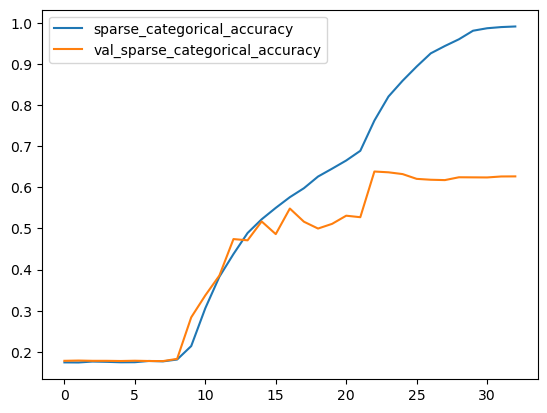

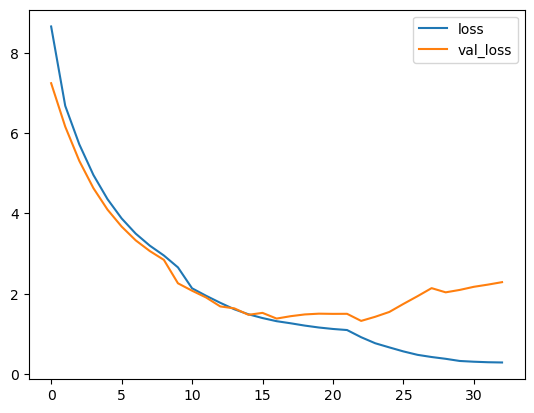

In [10]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-50 - training and evaluation

In [11]:
wandb.init(config=config, project='resnet', name='resnet50')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet50(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
581/581 [==============================] - 40s 58ms/step - loss: 17.6032 - sparse_categorical_accuracy: 0.1711 - val_loss: 15.2172 - val_sparse_categorical_accuracy: 0.1832 - lr: 0.1000
Epoch 2/100
581/581 [==============================] - 32s 55ms/step - loss: 13.8044 - sparse_categorical_accuracy: 0.1746 - val_loss: 12.4789 - val_sparse_categorical_accuracy: 0.1832 - lr: 0.1000
Epoch 3/100
581/581 [==============================] - 32s 55ms/step - loss: 11.3538 - sparse_categorical_accuracy: 0.1750 - val_loss: 10.3040 - val_sparse_categorical_accuracy: 0.1954 - lr: 0.1000
Epoch 4/100
581/581 [==============================] - 32s 55ms/step - loss: 9.1762 - sparse_categorical_accuracy: 0.2413 - val_loss: 8.0952 - val_sparse_categorical_accuracy: 0.3035 - lr: 0.1000
Epoch 5/100
581/581 [==============================] - 32s 54ms/step - loss: 7.4109 - sparse_categorical_accuracy: 0.3267 - val_loss: 6.6950 - val_sparse_categorical_accuracy: 0.3773 - lr: 0.1000
Epoch 6/100
58

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████████████████████████▂▂▂▂▂▁
epoch/loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████████████████████▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇██
epoch/val_loss,█▇▅▄▄▃▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▁▁▃▄▅▅▆▅▆▅▆▆▆▆▆▇▆▇▇▇▅▆▆▇▇█████
epoch/epoch,30
epoch/learning_rate,0.001
epoch/loss,0.62495
epoch/lr,0.01


182/182 [==============================] - 4s 23ms/step - loss: 1.5866 - sparse_categorical_accuracy: 0.5269


[1.586639642715454, 0.5268595218658447]

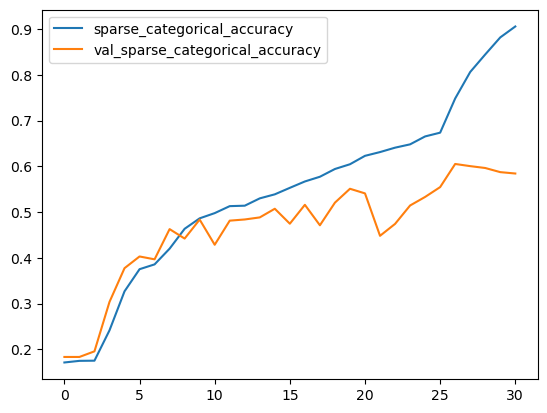

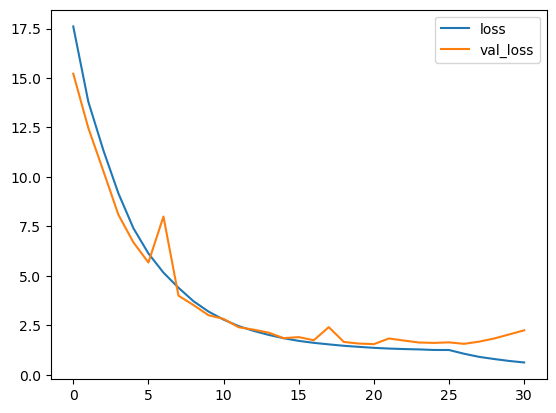

In [12]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-101 - training and evaluation

In [13]:
wandb.init(config=config, project='resnet', name='resnet101')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet101(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
581/581 [==============================] - 67s 95ms/step - loss: 114.6342 - sparse_categorical_accuracy: 0.1671 - val_loss: 103.9712 - val_sparse_categorical_accuracy: 0.1769 - lr: 0.1000
Epoch 2/100
581/581 [==============================] - 53s 91ms/step - loss: 92.9992 - sparse_categorical_accuracy: 0.1726 - val_loss: 82.7955 - val_sparse_categorical_accuracy: 0.1776 - lr: 0.1000
Epoch 3/100
581/581 [==============================] - 53s 92ms/step - loss: 74.1084 - sparse_categorical_accuracy: 0.1706 - val_loss: 66.0236 - val_sparse_categorical_accuracy: 0.1793 - lr: 0.1000
Epoch 4/100
581/581 [==============================] - 53s 91ms/step - loss: 59.1415 - sparse_categorical_accuracy: 0.1723 - val_loss: 52.7313 - val_sparse_categorical_accuracy: 0.1778 - lr: 0.1000
Epoch 5/100
581/581 [==============================] - 54s 93ms/step - loss: 47.2833 - sparse_categorical_accuracy: 0.1757 - val_loss: 42.2048 - val_sparse_categorical_accuracy: 0.1780 - lr: 0.1000
Epoch 6/

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,██████████████████████████████▂▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,███████████████████████████████▂▂▂▂▂▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▁▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇████
epoch/val_loss,█▇▅▅▄▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▂▂▂▂▂▂▄▃▅▆▆▆▆▆▆▇▇▇▆▆▇▇▆▇▇▁▇▇▇▇▇█████████
epoch/epoch,46
epoch/learning_rate,0.0001
epoch/loss,0.5087
epoch/lr,0.001


182/182 [==============================] - 6s 32ms/step - loss: 1.4547 - sparse_categorical_accuracy: 0.5933


[1.4547021389007568, 0.5933195352554321]

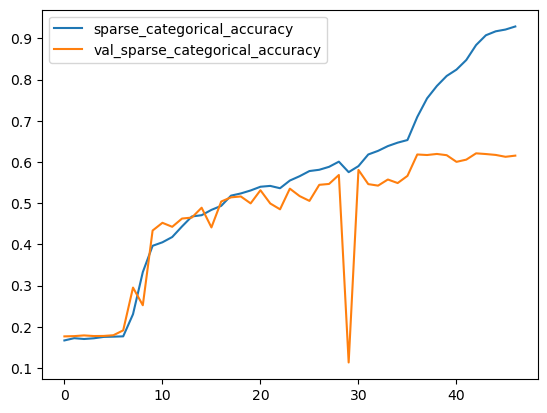

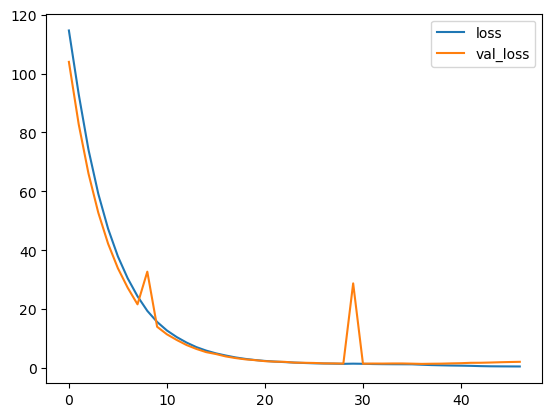

In [14]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-152 - training and evaluation

In [15]:
wandb.init(config=config, project='resnet', name='resnet152')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet152(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
581/581 [==============================] - 93s 130ms/step - loss: 1148.8154 - sparse_categorical_accuracy: 0.1775 - val_loss: 1048.8047 - val_sparse_categorical_accuracy: 0.1771 - lr: 0.1000
Epoch 2/100
581/581 [==============================] - 72s 123ms/step - loss: 936.0873 - sparse_categorical_accuracy: 0.1759 - val_loss: 831.3691 - val_sparse_categorical_accuracy: 0.1771 - lr: 0.1000
Epoch 3/100
581/581 [==============================] - 72s 124ms/step - loss: 742.0668 - sparse_categorical_accuracy: 0.1749 - val_loss: 659.1003 - val_sparse_categorical_accuracy: 0.1793 - lr: 0.1000
Epoch 4/100
581/581 [==============================] - 72s 124ms/step - loss: 588.3502 - sparse_categorical_accuracy: 0.1768 - val_loss: 522.6193 - val_sparse_categorical_accuracy: 0.1797 - lr: 0.1000
Epoch 5/100
581/581 [==============================] - 72s 125ms/step - loss: 466.5623 - sparse_categorical_accuracy: 0.1739 - val_loss: 414.4804 - val_sparse_categorical_accuracy: 0.1789 - lr: 

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch/loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▃▃▄▄▄▅▄▄▅▅▅▅▅▅▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
epoch/val_loss,█▇▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▂▂▂▂▂▅▄▆▁▆▇▁▇▇▇▇▇▇▆▂▆▇▇▇▇▇▇▇▇███▇▇██████
epoch/epoch,71
epoch/learning_rate,0.0001
epoch/loss,0.92419
epoch/lr,0.001


182/182 [==============================] - 8s 45ms/step - loss: 1.6470 - sparse_categorical_accuracy: 0.5522


[1.6470412015914917, 0.5521694421768188]

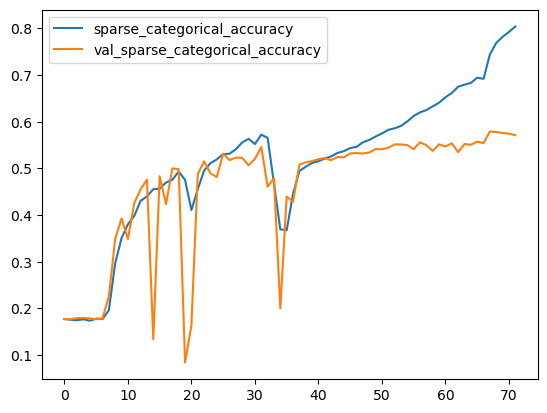

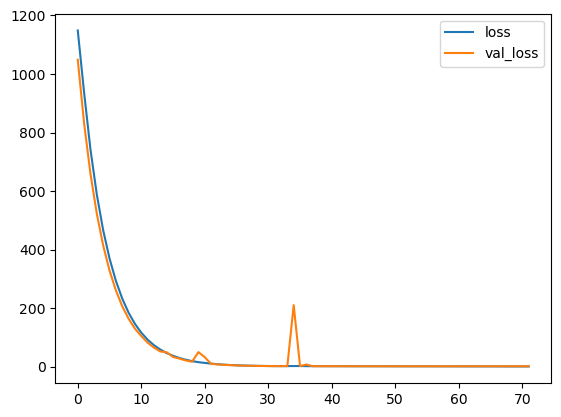

In [16]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)